# **PMR3508(2020) - APRENDIZADO DE MÁQUINA E RECONHECIMENTO DE PADRÕES**
Aplicação de redes neurais para a análise de sentimento em textos;

Autor: Gabriel Ranieri Vaz de Lima

# 1. Preparação dos dados (*Data Prep*)

* Importações de Bibliotecas

In [1]:
!pip install gensim
!pip install ftfy

     |████████████████████████████████| 64 kB 513 kB/s 
  Created wheel for ftfy: filename=ftfy-5.8-py3-none-any.whl size=45612 sha256=efe0f418f4ca45bd316bde3dbe98d3a469893b9853cfd5df6c8f4a93cd11bcfb
  Stored in directory: /root/.cache/pip/wheels/49/1c/fc/8b19700f939810cd8fd9495ae34934b246279791288eda1c31
Successfully built ftfy


In [2]:
#Para o uso geral
import random
import numpy as np
import pandas as pd
import copy 
import time
from tqdm import tqdm as tqdm
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

#Para o processamento de textos
from ftfy import fix_text
import string
import re
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Para Machine Learning e MLP
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#Importando funcionalidades do Tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense
from tensorflow.python.framework import ops
from tensorflow.keras.callbacks import EarlyStopping

* Importação de Dados

In [3]:
data_train = pd.read_csv("../input/sentiment-analysis-pmr3508/data_train.csv") #Dados de Treino

data_test1 = pd.read_csv("../input/sentiment-analysis-pmr3508/data_test1.csv") #Dados de Teste para a comparação dos classificadores

data_test2 = pd.read_csv("../input/sentiment-analysis-pmr3508/data_test2_X.csv") #Dados de Teste para a submissão das probabilidades

data_train.head()

,review,positive
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


* Preparção Geral dos Dados

In [4]:
print('Formato do DataFrame: ', data_train.shape)

Formato do DataFrame:  (24984, 2)


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24984 entries, 0 to 24983
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    24984 non-null  object
 1   positive  24984 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.5+ KB


A partir do Formato do Dataframe e de suas informações, verifica-se que inexistem dados faltantes.

In [6]:
#Número de duplicatas (True)
duplicated_data = data_train.duplicated()
duplicated_data.value_counts()

False    24888
True        96
dtype: int64

In [7]:
#Exemplos de dados duplicados
duplicated_data = data_train.duplicated(keep = False)
data_train.loc[duplicated_data == True].head() 

,review,positive
194,Though structured totally different from the b...,1
197,Though structured totally different from the b...,1
1629,Everyone knows about this ''Zero Day'' event. ...,1
1631,Everyone knows about this ''Zero Day'' event. ...,1
2132,One of Disney's best films that I can enjoy wa...,1


Encontaram-se 96 duplicatas de dados. Estes textos serão desconsiderados, pois provavelmente são fruto de erros de coleta.

In [8]:
#Retirando as linhas duplicadas
data_train= data_train.drop_duplicates(keep= 'last') 
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24888 entries, 0 to 24983
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    24888 non-null  object
 1   positive  24888 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 583.3+ KB


* Limpeza e Padronização dos textos

In [9]:
#Distribuição de positive
data_train['positive'].value_counts() 

1    12461
0    12427
Name: positive, dtype: int64

In [10]:
#Criação das listas X_train e Y_train contendo reviews e a classificação positive, respectivamente.

X_train = data_train['review'].tolist()
Y_train = data_train['positive'].tolist()

In [11]:
X_train[10] #Uma das reviews

'When I first read Armistead Maupins story I was taken in by the human drama displayed by Gabriel No one and those he cares about and loves. That being said, we have now been given the film version of an excellent story and are expected to see past the gloss of Hollywood...<br /><br />Writer Armistead Maupin and director Patrick Stettner have truly succeeded! <br /><br />With just the right amount of restraint Robin Williams captures the fragile essence of Gabriel and lets us see his struggle with issues of trust both in his personnel life(Jess) and the world around him(Donna).<br /><br />As we are introduced to the players in this drama we are reminded that nothing is ever as it seems and that the smallest event can change our lives irrevocably. The request to review a book written by a young man turns into a life changing event that helps Gabriel find the strength within himself to carry on and move forward.<br /><br />It\'s to bad that most people will avoid this film. I only say th

Ao se observar o texto acima, percebe-se a importância da realização de limpeza e padronização de todos os textos antes de tranformá-los em vetores de representação.

In [12]:
#Defini-se a função para a limpeza do texto
def clean(text):
    txt=text.replace("<br />"," ") #retirando tags
    txt=fix_text(txt) #consertando Mojibakes (Ver https://pypi.org/project/ftfy/)
    txt=txt.lower() #passando tudo para minúsculo
    txt=txt.translate(str.maketrans('', '', string.punctuation)) #retirando toda pontuação
    txt=txt.replace(" — ", " ") #retirando hífens
    txt=re.sub("\d+", ' <number> ', txt) #colocando um token especial para os números
    txt=re.sub(' +', ' ', txt) #deletando espaços extras
    return txt

In [13]:
#Limpeza e padronização das reviews
X_train = [clean(x) for x in X_train]

In [14]:
X_train[10]

'when i first read armistead maupins story i was taken in by the human drama displayed by gabriel no one and those he cares about and loves that being said we have now been given the film version of an excellent story and are expected to see past the gloss of hollywood writer armistead maupin and director patrick stettner have truly succeeded with just the right amount of restraint robin williams captures the fragile essence of gabriel and lets us see his struggle with issues of trust both in his personnel lifejess and the world around himdonna as we are introduced to the players in this drama we are reminded that nothing is ever as it seems and that the smallest event can change our lives irrevocably the request to review a book written by a young man turns into a life changing event that helps gabriel find the strength within himself to carry on and move forward its to bad that most people will avoid this film i only say that because the average american will probably think robin wil

O texto acima foi padronizado e está pronto para ser convertido em um vetor de representação.

In [15]:
X_train = [x.split() for x in X_train] #Tokenização das reviews

# 2. Utilização de Doc2Vec nos textos
Neste segmento, utiliza-se um modelo já pré-treinado de Doc2Vec para se obter representaçõess vetoriais de cada texto. Toma-se como referência o notebook *analise_de_sentimentos.ipynb*.

In [16]:
d2v = Doc2Vec.load('../input/sentiment-analysis-pmr3508/doc2vec') 

Abaixo, define-se a função que gera as representações vetoriais, a partir dos textos padronizados, pela utilização do modelo pré-treinado de Doc2Vec.

In [17]:
def emb(txt, model, normalize=False): 
    model.random.seed(42)
    x=model.infer_vector(txt, steps=20)
    
    if normalize: return(x/np.sqrt(x@x))
    else: return(x)

In [18]:
#Aplicação da função nas reviews
X_train = [emb(x, d2v) for x in X_train] 
X_train = np.array(X_train)

In [19]:
X_train.shape #Formato do Array

(24888, 50)

In [20]:
X_train[10]

array([-1.035692  , -0.60179144, -0.2627422 ,  0.10552399, -0.44455606,
        0.14752208, -0.6457975 , -0.1008198 ,  0.12255809, -0.8152826 ,
       -1.4546576 , -1.1043218 ,  0.13409172, -0.36594978, -0.44487834,
        0.8713211 ,  0.7220229 ,  0.86481625, -0.40354726, -0.45300376,
        1.0102469 ,  0.8546184 ,  0.05695517, -0.97015107,  0.6258848 ,
        0.5913712 ,  1.4019544 , -0.07450695, -1.3825638 , -0.31807527,
       -0.949131  , -0.18412402, -0.49575144, -0.22880085, -0.4390179 ,
       -0.43560728, -0.16359967, -0.56014234, -0.36046463, -0.7693279 ,
        0.09823471,  0.13543949, -0.7366606 ,  0.4950106 ,  0.4884849 ,
       -0.9777481 ,  0.81989026, -0.43340996, -0.2008631 , -0.25061116],
      dtype=float32)

Acima, observa-se a representação vetorial do texto utilizado como exemplo anteriormente.

# 3. Treinamento de Redes Neurais pela implementação de Scikit-Learn
Neste segmento, faz-se o treinamento de duas redes neurai: a primeira com apenas uma camada oculta e a segunda com 2. Com esse objetivo, implemeta-se o Multi-layer Perceptron Classifier de Scikit-learn.

* Uma camada oculta (MLP1)

In [21]:
mlp = MLPClassifier(early_stopping = True) # Multi-layer Perceptron Classifier

params = {'hidden_layer_sizes': [n for n in range(0, 181, 3)], #Quantidade de neurônios na camada oculta
         'activation': ['relu'], #A função de ativação: Rectified Linear Unit (ReLu)
         'solver': ['adam'], #O otimizador dos pesos
         'alpha': [0, 1e-15, 1e-10, 1e-5, 1e-3, 1e-2, 1e-1], #Termo de regularização
         'learning_rate': ['constant']} #Taxa de Aprendizagem para atualizações de pesos

clf = GridSearchCV(mlp, params, n_jobs = -1, verbose = 1, cv=5, scoring = 'roc_auc') #Maximização dos Parâmetros
clf.fit(X_train, Y_train)

Fitting 5 folds for each of 427 candidates, totalling 2135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 2135 out of 2135 | elapsed: 35.7min finished


GridSearchCV(cv=5, estimator=MLPClassifier(early_stopping=True), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'alpha': [0, 1e-15, 1e-10, 1e-05, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [0, 3, 6, 9, 12, 15, 18, 21, 24,
                                                27, 30, 33, 36, 39, 42, 45, 48,
                                                51, 54, 57, 60, 63, 66, 69, 72,
                                                75, 78, 81, 84, 87, ...],
                         'learning_rate': ['constant'], 'solver': ['adam']},
             scoring='roc_auc', verbose=1)

In [22]:
clf.best_params_

{'activation': 'relu',
 'alpha': 0.01,
 'hidden_layer_sizes': 180,
 'learning_rate': 'constant',
 'solver': 'adam'}

In [23]:
#Cria uma lista com os melhores parâmetros encontrados

best_params = clf.best_params_

mlp1_best_params = list(best_params.values())

print('Os melhores parâmetros são: ', mlp1_best_params)

Os melhores parâmetros são:  ['relu', 0.01, 180, 'constant', 'adam']


In [24]:
clf.best_score_ #Maior valor de AUC encontrado

0.89108604324061

* Duas camadas ocultas (MLP2)

In [25]:
mlp = MLPClassifier(early_stopping = True) #Multi-layer Perceptron Classifier

params= {'hidden_layer_sizes':[(n1,n2) for n1 in range(0, 121, 5) for n2 in range(0, n1, 5)], #Quantidades de neurônios nas camadas ocultas
        'activation': ['relu'], #A função de ativação: Rectified Linear Unit (ReLu)
        'solver':['adam'], #O otimizador dos pesos
        'alpha': [0, 1e-15, 1e-10, 1e-5, 1e-3, 1e-2, 1e-1], #Termo de regularização
        'learning_rate':['constant']} #Taxa de Aprendizagem para atualizações de peso

clf2 = GridSearchCV(mlp, params, n_jobs = -1, verbose = 1, cv=5, scoring = 'roc_auc') #Maximização dos Parâmetros
clf2.fit(X_train,Y_train)

Fitting 5 folds for each of 2100 candidates, totalling 10500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 1254 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 1804 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 2454 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done 3204 tasks      | elapsed: 60.2min
[Parallel(n_jobs=-1)]: Done 4054 tasks      | elapsed: 76.0min
[Parallel(n_jobs=-1)]: Done 5004 tasks      | elapsed: 94.1min
[Parallel(n_jobs=-1)]: Done 6054 tasks      | elapsed: 115.8min
[Parallel(n_jobs=-1)]: Done 7204 tasks      | elapsed: 136.9min
[Parallel(n_jobs=-1)]: Done 8454 tasks      | elapsed: 160.3min
[Parallel(n_jobs=-1)]: Done 9804 tasks      | elapsed: 187.0min
[Parallel(n_jobs=-1)]: Done 10500 out of 1

GridSearchCV(cv=5, estimator=MLPClassifier(early_stopping=True), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'alpha': [0, 1e-15, 1e-10, 1e-05, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(5, 0), (10, 0), (10, 5),
                                                (15, 0), (15, 5), (15, 10),
                                                (20, 0), (20, 5), (20, 10),
                                                (20, 15), (25, 0), (25, 5),
                                                (25, 10), (25, 15), (25, 20),
                                                (30, 0), (30, 5), (30, 10),
                                                (30, 15), (30, 20), (30, 25),
                                                (35, 0), (35, 5), (35, 10),
                                                (35, 15), (35, 20), (35, 25),
                                                (35, 30), (40, 0), (40, 5), ...],
                         'l

In [26]:
clf2.best_params_

{'activation': 'relu',
 'alpha': 1e-15,
 'hidden_layer_sizes': (115, 75),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [27]:
#Cria uma lista com os melhores parâmetros encontrados

best_params = clf2.best_params_

mlp2_best_params = list(best_params.values())

print('Os melhores parâmetros são: ', mlp2_best_params)

Os melhores parâmetros são:  ['relu', 1e-15, (115, 75), 'constant', 'adam']


In [28]:
clf2.best_score_ #Maior valor de AUC encontrado

0.8916200580824618

# 4.Treinamento de Redes Neurais Artificiais com Tensorflow 2 e Keras 
Neste segmento, treina-se uma rede neural com 2 camadas ocultas (TF2), implementando-se Tensorflow 2 e Keras. Toma-se como referência o notebook *tensorflow-keras.ipynb*.

In [29]:
Y_train=np.array(Y_train) 

Precisa-se, primeiro, dividir os dados de treino para gerar aqueles que serão usados como validação:

In [30]:
X_train_t, X_train_val, Y_train_t, Y_train_val = train_test_split(X_train, Y_train,
                                                            test_size=0.2, random_state=42)

Com o objetivo de maximizar os parâmetros dessa rede neural, faz-se buscas aleatórias em possíveis valores desses parâmetros, tais valores então são testados.

In [31]:
n_features = 50 
n_iter = 500

neurons=[] #Lista destinada às quantidades de neurônios nas respectivas camadas ocultas
reg = [] #Lista destinada aos valores dos parâmetros de regularização

for i in range(n_iter): #Insere valores aleatórios na lista neurons
    n1 = random.randrange(3,160,1)
    n2 = random.randrange(1, n1,1)
    neurons.append((n1,n2))
    
    L1 = random.choice([0, 1e-15, 1e-10, 1e-5, 1e-3, 1e-2, 1e-1]) #Insere valores aleatórios na lista reg
    L2 = random.choice([0, 1e-15, 1e-10, 1e-5, 1e-3, 1e-2, 1e-1])
    reg.append((L1,L2))
    
#Cria um DataFrame com as listas compostas pelos valores sorteados
#Adiciona as colunas epochs e auc que ainda serão preenchidas
params = {'neurons': neurons, 'reg': reg, 'epochs':n_iter*[None], 'auc':n_iter*[None]} 
params = pd.DataFrame(params)
params = params[['neurons', 'reg', 'epochs', 'auc']]

In [32]:
params.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   neurons  500 non-null    object
 1   reg      500 non-null    object
 2   epochs   0 non-null      object
 3   auc      0 non-null      object
dtypes: object(4)
memory usage: 15.8+ KB


In [33]:
params.head()

,neurons,reg,epochs,auc
0,"(5, 1)","(0, 0.1)",None,None
1,"(27, 9)","(0, 1e-15)",None,None
2,"(107, 95)","(0.01, 0)",None,None
3,"(142, 31)","(1e-10, 1e-10)",None,None
4,"(70, 19)","(1e-10, 0.1)",None,None


In [34]:
#Esta função gera modelos de redes neurais
def model_creator(neurons=(10,10), reg=(0.001,0.001)):
    
    ops.reset_default_graph() #Reseta os grafos das redes neurais
    
    model = Sequential()
    model.add(Dense(neurons[0], input_shape=(n_features,), activation='relu', 
                    kernel_regularizer=regularizers.l1_l2(l1=reg[0], l2=reg[1]), 
                    bias_regularizer=regularizers.l1_l2(l1=reg[0], l2=reg[1])))
    model.add(Dense(neurons[1], activation='relu', 
                    kernel_regularizer=regularizers.l1_l2(l1=reg[0], l2=reg[1]), 
                    bias_regularizer=regularizers.l1_l2(l1=reg[0], l2=reg[1])))
    model.add(Dense(1, activation='sigmoid', 
                    kernel_regularizer=regularizers.l1_l2(l1=reg[0], l2=reg[1]), 
                    bias_regularizer=regularizers.l1_l2(l1=reg[0], l2=reg[1])))
    
    #Compilação
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    return model

In [35]:
for j in range(n_iter):
    model = model_creator(params.loc[j, 'neurons'], params.loc[j, 'reg'])
    
    #Testagem do modelo com os possíveis valores dos parâmetros
    tf2 = model.fit(X_train_t, Y_train_t, epochs=30, validation_data=(X_train_val, Y_train_val),
                        batch_size=366, shuffle=True, verbose=False, workers = -1, use_multiprocessing = True,
                        callbacks=[EarlyStopping(monitor='val_auc',patience=10)])
    
    #Inserção dos valores obtidos dos epochs e auc
    params.loc[j,'epochs'] = len(tf2.history['val_auc'])
    params.loc[j,'auc']=tf2.history['val_auc'][-1]
    
    #Progresso
    if (j+1)%int(n_iter/10)==0: print('{:.2f}% concluded.'.format(100*(j+1)/n_iter))
    else: pass
    

10.00% concluded.
20.00% concluded.
30.00% concluded.
40.00% concluded.
50.00% concluded.
60.00% concluded.
70.00% concluded.
80.00% concluded.
90.00% concluded.
100.00% concluded.


In [36]:
params.head()

,neurons,reg,epochs,auc
0,"(5, 1)","(0, 0.1)",19,0.5
1,"(27, 9)","(0, 1e-15)",11,0.893965
2,"(107, 95)","(0.01, 0)",12,0.5
3,"(142, 31)","(1e-10, 1e-10)",11,0.895382
4,"(70, 19)","(1e-10, 0.1)",17,0.5


Após a testagem do modelo, identificam-se os melhores parâmetros:

In [37]:
#Ranqueamento com base nos valores de auc obtidos
rank = np.argsort(params.loc[:,'auc'])
rank = params.iloc[rank[::-1],:]
rank.head(1)

,neurons,reg,epochs,auc
47,"(154, 84)","(1e-10, 0.001)",11,0.901067


In [38]:
#Cria uma lista com os melhores parâmetros encontrados
neu = rank['neurons'].tolist()
regu = rank['reg'].tolist()
epochs = rank['epochs'].tolist()

tf2_best_params = [neu[0],regu[0], epochs[0]]
print('Os melhores parâmetros são: ', tf2_best_params)

Os melhores parâmetros são:  [(154, 84), (1e-10, 0.001), 11]


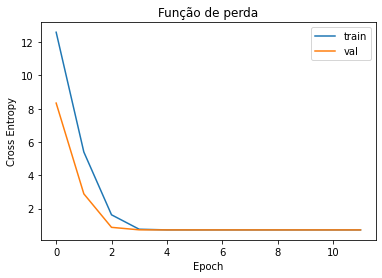

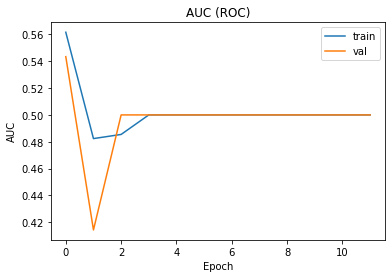

In [39]:
#Função de perda
plt.title('Função de perda')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(tf2.history['loss'], label='train')
plt.plot(tf2.history['val_loss'], label='val')
plt.legend()
plt.show()

#AUC
plt.title('AUC (ROC)')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.plot(tf2.history['auc'], label='train')
plt.plot(tf2.history['val_auc'], label='val')
plt.legend()
plt.show()

Os gráficos acima ilustram as funções de perda e AUC(ROC).

# 5. Comparação de Performance dos Classificadores
Neste segmento, os classificadores recebem um conjunto de teste e se comparam os resultados obtidos por cada um.

* Transformação dos Dados de Teste

Primeiro, faz-se o mesmo tratamento de dados nos de teste.

In [40]:
#Criação das listas X_test1 e Y_test2 contendo reviews e a classificação positive, respectivamente.

X_test1 = data_test1['review'].tolist()
Y_test1 = data_test1['positive'].tolist()

In [41]:
X_test1 = [clean(x) for x in X_test1] #Limpeza e padronização das reviews

X_test1 = [x.split() for x in X_test1] #Tokenização das reviews

X_test1 = [emb(x, d2v) for x in X_test1] #Aplicação da função nas reviews

X_test1 = np.array(X_test1)

In [42]:
Y_test1 = np.array(Y_test1)

In [43]:
Y_test1.shape

(12492,)

* Classificação de Performance:

In [44]:
print(mlp1_best_params) #Melhores parâmetros de MLP1

['relu', 0.01, 180, 'constant', 'adam']


In [45]:
print(mlp2_best_params) #Melhores parâmetros de MLP2

['relu', 1e-15, (115, 75), 'constant', 'adam']


In [46]:
print(tf2_best_params) #Melhores parâmetros de TF2

[(154, 84), (1e-10, 0.001), 11]


Acima, verifica-se os melhores parâmetros encontrados para cada classificador, em seguida faz-se o treinamento de cada um com estes parâmetros.

In [47]:
#Classificadores treinados com seus parâmetros maximizados:
mlp1 = MLPClassifier(early_stopping = True,
                     activation = mlp1_best_params[0],
                     alpha = mlp1_best_params[1],
                     hidden_layer_sizes = mlp1_best_params[2],
                     learning_rate = mlp1_best_params[3],
                     solver = mlp1_best_params[4])

mlp1.fit(X_train,Y_train)


mlp2 = MLPClassifier(early_stopping = True,
                     activation = mlp2_best_params[0],
                     alpha = mlp2_best_params[1],
                     hidden_layer_sizes = mlp2_best_params[2],
                     learning_rate = mlp2_best_params[3],
                     solver = mlp2_best_params[4])

mlp2.fit(X_train, Y_train)



tf2 = model_creator(tf2_best_params[0], tf2_best_params[1])

tf2.fit(X_train_t, Y_train_t,
        validation_split =0,
        epochs = tf2_best_params[2],
        batch_size = 362,
        shuffle = True,
        verbose = False)


Então, com os classificadores treinados, faz-se a predição dos valores alvos com base nos dados de teste.

In [48]:
#Predições e scores de cada um dos três classificadores
mlp1_auc = roc_auc_score(Y_test1, mlp1.predict_proba(X_test1)[:,1])

mlp2_auc = roc_auc_score(Y_test1, mlp2.predict_proba(X_test1)[:,1])

tf2_auc = roc_auc_score(Y_test1, tf2.predict(X_test1))

In [49]:
#Cria um DataFrame com os scores de cada classificador
performance={"Classificador": ['MLP-1HL', 'MLP-2HL', 'TF2-2HL'], 'AUC': [mlp1_auc, mlp2_auc, tf2_auc]}
performance = pd.DataFrame(performance, columns = ['Classificador', 'AUC'])
performance

,Classificador,AUC
0,MLP-1HL,0.893154
1,MLP-2HL,0.891397
2,TF2-2HL,0.890606


In [50]:
best_score= np.max(performance['AUC'])
best_score

0.8931539376680138

Observa-se que a diferença na performance dos três classificadores é bem pequena, mas escolhe-se o Multi-layer Perceptron com 2 camadas ocultas.

# 6. Submissão
Por fim, aplica-se o melhor classicador no conjunto teste de submissão.

Faz-se o tratamento nos dados de teste de submissão:

In [51]:
#Criação das lista X_test2 contendo reviews.

X_test2 = data_test2['review'].tolist()

In [52]:
X_test2 = [clean(x) for x in X_test2] #Limpeza e padronização das reviews

X_test2 = [x.split() for x in X_test2] #Tokenização das reviews

X_test2 = [emb(x, d2v) for x in X_test2] #Aplicação da função nas reviews

X_test2 = np.array(X_test2)

Faz-se as predições das probabilidades alvo:

In [53]:
#Predições
predictions = mlp2.predict_proba(X_test2)[:,1]
submission = pd.DataFrame({'positive':predictions})
submission.head()

,positive
0,0.000540
1,0.408014
2,0.008579
3,0.068661
4,0.044437


Finalmente, converte-se o DataFrame que contém as predições em csv para submissão:

In [54]:
submission.to_csv("submission.csv", index = True, index_label = 'Id')